## Shakespear-like poem generation on character level

##### Flipflop vs LSTM comparison


Code taken from: 
[Tensorflow documentation on RNN](https://www.tensorflow.org/tutorials/text/text_generation)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/13YaGMPsmJ4MNgE3cKcUjOws31PRCC9Km/view?usp=sharing)

Some samples of data
<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.
</pre>

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, RNN
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
import numpy as np
import os
import time

##### Download the Shakespeare dataset


In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')

Now create the `preprocessing.StringLookup` layer:

In [ ]:
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab), mask_token=None)

It converts form tokens to character IDs:

In [ ]:
ids = ids_from_chars(chars)

In [ ]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [ ]:
chars = chars_from_ids(ids)

You can `tf.strings.reduce_join` to join the characters back into strings. 

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
# Batch size
BATCH_SIZE = 512

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((512, 100), (512, 100)), types: (tf.int64, tf.int64)>

#### Build The Model

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.117.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.117.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class LSTM_model(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, h, c = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, [h,c]
    else:
      return x

## Train the model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
EPOCHS = 100

with strategy.scope():
  lstm_model = LSTM_model(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
  for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = lstm_model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
  adam = tf.keras.optimizers.Adam(learning_rate=0.01)
  lstm_model.compile(optimizer=adam, loss=loss)
  lstm_history = lstm_model.fit(dataset, epochs=EPOCHS)

(512, 100, 66) # (batch_size, sequence_length, vocab_size)
Epoch 1/100
21/21 [==============================] - 6s 53ms/step - loss: 4.8774
Epoch 2/100
21/21 [==============================] - 2s 53ms/step - loss: 3.4139
Epoch 3/100
21/21 [==============================] - 2s 52ms/step - loss: 2.9872
Epoch 4/100
21/21 [==============================] - 2s 52ms/step - loss: 2.6231
Epoch 5/100
21/21 [==============================] - 2s 52ms/step - loss: 2.4268
Epoch 6/100
21/21 [==============================] - 2s 52ms/step - loss: 2.3081
Epoch 7/100
21/21 [==============================] - 2s 53ms/step - loss: 2.2244
Epoch 8/100
21/21 [==============================] - 2s 52ms/step - loss: 2.1526
Epoch 9/100
21/21 [==============================] - 2s 53ms/step - loss: 2.0866
Epoch 10/100
21/21 [==============================] - 2s 53ms/step - loss: 2.0286
Epoch 11/100
21/21 [==============================] - 2s 52ms/step - loss: 1.9783
Epoch 12/100
21/21 [============================

In [ ]:
lstm_model.summary()

Model: "lstm_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  16896     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
dense_12 (Dense)             multiple                  67650     
Total params: 5,331,522
Trainable params: 5,331,522
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([25, 20, 50, 31, 50, 33, 27, 40,  7,  7, 51,  4, 53, 27, 44, 53, 13,
       33, 40, 52, 29, 57, 58, 13, 45, 13, 23, 58, 17, 36, 20, 15, 42, 25,
       35, 45, 61,  9, 53, 54,  2, 18, 64, 48, 14, 24, 58, 13, 37, 30, 19,
        6, 36,  7, 50,  3,  4,  0, 54, 24, 53, 25, 34, 19, 61, 20, 14, 63,
       26, 15, 52, 38, 56, 29, 32, 24, 36,  5, 45, 34,  9, 58, 49, 61, 20,
       38,  3, 20, 23, 35, 54, 25,  3, 16, 44,  0, 63, 31, 60, 59])

#### Generate text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
lstm_one_step_model = OneStep(lstm_model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = lstm_one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
As his hell and false Edward up the city.
This is the lettles will do growly repair.
Your gracious lords, woe poin a father,
Your trial off have done enmity: it is:
Thus did I seek for this affections to me;
For one show found his grave is little sprintly.
Here lives a man,
Though you have learn'd it-off,' ten times does
Against the doubled another house,
That clost his inching youth: my goes may speak
Awayers: abids, Signior York!
Offer my services have fall'd moon he kiss
'The issue without the thirds of enemiase
That raised me to keep you finder
As may we saw him friendly prayded;
Mine state was too our deflory.

Second Musician:
Pats I here's over have stretch'd your country's arms;
Before: trembling one, so light,
And am the scapes of teempe, my bed, flower:
but I; all thesen blows not wondering.

LARTIUS:
So shall I give; my lord; the people's true, o
wast, fortune, fire, not for thy peace. Blossed, all; poor life,
Maybe; for, I'll be with you: he majest,
The provend on a 

With flipflop

In [ ]:
class FF(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        super(FF, self).__init__(**kwargs)
        self.units = units
        self.state_size = units
        self.j_h = keras.layers.Dense(self.units)
        self.j_x = keras.layers.Dense(self.units)
        self.k_h = keras.layers.Dense(self.units)
        self.k_x = keras.layers.Dense(self.units)

    def build(self, input_shape):
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        j = tf.sigmoid(self.j_x(inputs) + self.j_h(prev_output))
        k = tf.sigmoid(self.k_x(inputs) + self.k_h(prev_output))
        output = j * (1 - prev_output) + (1 - k) * prev_output
        return output, [output]

In [ ]:
class FF_model(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.RNN(FF(rnn_units),
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
with strategy.scope():
  ff_model = FF_model(
      # Be sure the vocabulary size matches the `StringLookup` layers.
      vocab_size=len(ids_from_chars.get_vocabulary()),
      embedding_dim=embedding_dim,
      rnn_units=rnn_units)
  for input_example_batch, target_example_batch in dataset.take(1):
      example_batch_predictions = ff_model(input_example_batch)
      print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
  print(ff_model.summary())
  adam = tf.keras.optimizers.Adam(learning_rate=0.01)
  ff_model.compile(optimizer='adam', loss=loss)
  ff_history = ff_model.fit(dataset, epochs=EPOCHS)

(512, 100, 66) # (batch_size, sequence_length, vocab_size)
Model: "ff_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  16896     
_________________________________________________________________
rnn_1 (RNN)                  multiple                  2625536   
_________________________________________________________________
dense_11 (Dense)             multiple                  67650     
Total params: 2,710,082
Trainable params: 2,710,082
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
21/21 [==============================] - 5s 40ms/step - loss: 3.5585
Epoch 2/100
21/21 [==============================] - 2s 40ms/step - loss: 3.1889
Epoch 3/100
21/21 [==============================] - 2s 39ms/step - loss: 2.9339
Epoch 4/100
21/21 [==============================] - 2s 39ms/step - l

In [ ]:
ff_one_step_model = OneStep(ff_model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = ff_one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Is not it! Voluble; give your general saint;
She were all: this is come brush'd alove,
And traitor him for rude, that back again; yet sure,
Yet a mind bid me with repity here.

RICHOOS:
I have becamed done, as you perchance and tell thereof,
Both in the beggar hate, conlein on thy brother:
Yet beggar to the faith, yet he, as he' whom was
That I, unreasons, with a leave, and blunt goodly.

KING EDWARD IV:
Now it that violent cuttain
Presence; and weigh affection,
His troth?--'tod God, I!
Shall I am never speak, that I have gone.

Ventious,
She have is lates of that say the cincer:
Under the sortuness joy is fooler;
And rather mother from the banish.
Very go twal liberty, who comest thou
deny to and time, and soil-whum doublied mine.
Because hath he shall have entertatching dam
Our pace of darmward in govern wing
Of fly.

First Keeper: I willow'd with chamber, to been the people.
Call, not breathed more authority to with some
jefty malice; thou art dangerous are not news
Is news P

Visualizations

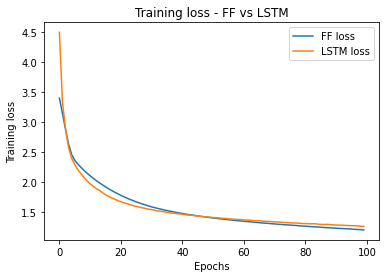

In [ ]:
from matplotlib import pyplot as plt
plt.plot(ff_history.history['loss'], label='FF loss')
plt.plot(lstm_history.history['loss'], label='LSTM loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.title("Training loss - FF vs LSTM")
plt.show()

In [ ]:
#save models
lstm_one_step_model.save_weights('lstm_one_step/checkpoint')
ff_one_step_model.save_weights('ff_one_step/checkpoint')